# 1. Introduction
The following contains the helper functions and code for the actual
experiments. Run with any Python intepreter after version 3.10 and
install all the necessary dependencies.

- NumPy
- Pandas
- Scikit-learn
- tqdm

Overall execution of the code takes about 10 min on a M1 Max cpu. Majority of the time
is spent on the main experiment.

In [ ]:
import os
import random
import numpy as np
import math
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])
            img_size = img.size

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels, img_size[::-1]


### 1.1 Load ORL Dataset and Extended YaleB Dataset.

-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [ ]:

# Load ORL dataset.
X_orl, Y_orl, shape_orl = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))
import numpy as np

# Load Extended YaleB dataset.
X_yale, Y_yale, shape_yale = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YaleB dataset: X.shape = {}, Y.shape = {}'.format(X_yale.shape, Y_yale.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YaleB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


## 1.2 Visualisation

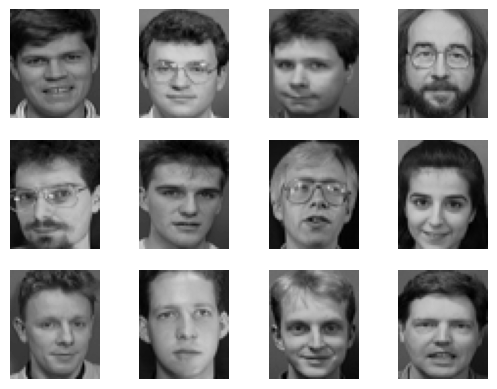

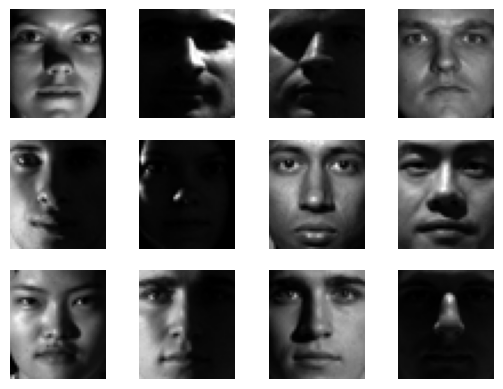

In [ ]:
import math
import matplotlib.pyplot as plt

PIXEL_MAX = 255

def display_images(X, width, height, n_sample=9, shuffle=False):
    # set the number of rows and columns for the images
    n_row = math.floor(math.sqrt(n_sample))
    n_col = math.ceil(n_sample / n_row)
    fig, axes = plt.subplots(n_row, n_col)
    indices = np.arange(X.shape[1])
    if shuffle:
        np.random.shuffle(indices)
    for i, ax in enumerate(axes.flatten()):
        if i >= n_sample:
            ax.remove()
            continue
        # reshape the image into the given width and height
        ax.imshow(X[:, indices[i]].reshape(width, height),
                  cmap="gray", vmax=PIXEL_MAX)
        ax.set_axis_off()

display_images(X_orl, *shape_orl, n_sample=12, shuffle=True)
display_images(X_yale, *shape_yale, n_sample=12, shuffle=True)

# 2. Methods

## 2.1 Helper Functions

In [ ]:
# create an initial nmf matrix that is random with k ass the number of components
def init_nmf(X, k):
    d, n = X.shape
    scale = np.sqrt(X.mean() / k)
    D = np.abs(np.random.randn(d, k)) * scale
    R = np.abs(np.random.randn(k, n)) * scale
    return D, R


# A helper class to check the loss delta and terminate the program early if the
# change in loss is not significant.
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: Number of epochs to wait after the last improvement.
        :param min_delta: Minimum percentage change in the loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.reset()

    def reset(self):
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, current_loss):
        # check if the loss has improved by threshold
        if current_loss < self.best_loss * (1 - self.min_delta):
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

## 2.2 L1-Norm NMF

Given a matrix where each column corresponds to one sample, the L1 norm loss is defined as the mean L1 norm of residuals of the reconstructed images. Formally, suppose there is a dataset $X \in \mathbb R_+^{m \times n}$ where $m$ is the number of features , and $n$ is the number of samples, the residual of a reconstruction using $D \in \mathbb R_+^{m \times r}$ and $R \in \mathbb R_+^{r \times n}$ is given by $E = X - DR$. The L1 norm loss is the mean of L1 norm of the columns of $E$,
$$
L = \frac{1}{n} \sum_{j=1}^n \lVert E_j\rVert
= \frac{1}{n} \sum_{j=1}^n \sum_{i=1}^m \lvert e_{ij}\rvert.
$$

Using gradient descent with learning rate $\eta$, an additive update rule for NMF with L1 loss is as follows,
\begin{align*}
D_{t+1} &= D_t + \frac{\eta}{n}\operatorname{sign}(E)R_t^T \\
R_{t+1} &= R_t + \frac{\eta}{n}D_{t+1}^T\operatorname{sign}(E)
\end{align*}
where $D_t$ and $R_t$ are $D$ and $R$ at the $t$-th iteration respectively.

Critically, the rules does not guarantee that the matrices are going to be positive even if it starts off positive ($D^0 \in \mathcal D$ and $R^0 \in \mathcal R$). Therefore, we clip the entries of both matrices to $[0, \infty)$ at the end of each iteration.

epoch = 0 loss = 108534.1945091208
epoch = 100 loss = 68896.24340538231
epoch = 200 loss = 48195.36529674869
epoch = 300 loss = 38955.242255411584
epoch = 400 loss = 34411.25025540104
epoch = 500 loss = 31563.818325595283
epoch = 600 loss = 29280.595162720754
epoch = 700 loss = 27201.55299444884
epoch = 800 loss = 25343.693378663746
epoch = 900 loss = 23689.25243818463


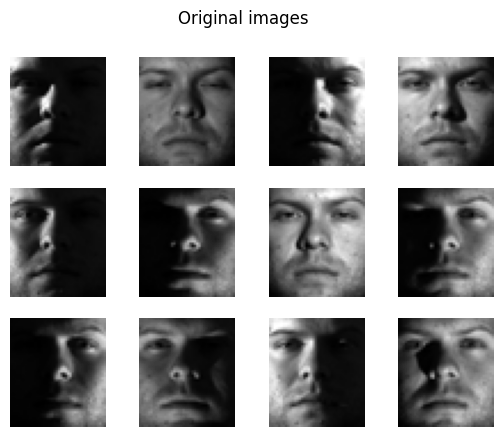

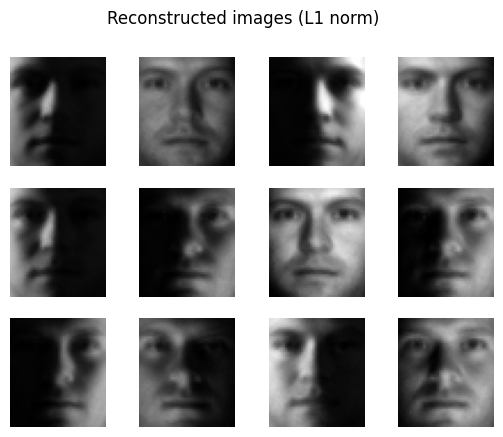

In [ ]:
# Perform gradient descent on the W and H matrix once, with a learning rate
# as hyperparameter input
def l1_norm_nmf_step(X, W, H, lr):
    d, n = X.shape
    WH = np.matmul(W, H)
    U = X - WH
    S = np.sign(U) / n
    W = np.clip(W + lr * np.matmul(S, H.T), 1e-7, np.inf)
    H = np.clip(H + lr * np.matmul(W.T, S), 1e-7, np.inf)
    loss = np.sum(S * U).item()
    return W, H, loss

# Iteratively gradient descent on W and H over multiple epochs.
def l1_norm_nmf(X, r, n_epoch, lr=1e-3,
                *,
                regularization=None,
                early_stopping=None,
                print_freq=None):
    d, n = X.shape
    if r < 1:
        r = int(round(r * d))
    W, H = init_nmf(X, r)
    if early_stopping is not None:
        early_stopping.reset()
    lr_ = lr
    for epoch in range(n_epoch):
        if callable(lr_):
            lr = lr_(epoch)
        W, H, loss = l1_norm_nmf_step(X, W, H, lr=lr)
        if regularization:
            W -= lr * regularization
            H -= lr * regularization
        if early_stopping and early_stopping(loss):
            break
        if print_freq and epoch % print_freq == 0:
            print(f"{epoch = } {loss = }")
    return W, H

# Test run of the l1 norm optimisation, with images to confirm that the model
# is behaving correctly
W, H = l1_norm_nmf(X_yale, 0.1, 1000, lr=0.05,
                   early_stopping=EarlyStopping(100, 0.01),
                   print_freq=100)

display_images(X_yale, *shape_yale, n_sample=12)
plt.suptitle("Original images")
display_images(W @ H, *shape_yale, n_sample=12)
plt.suptitle("Reconstructed images (L1 norm)")
plt.show()

## 2.3 NMF with Squared Frobenius Norm Loss

Traditionally, NMF uses the squared Frobenius norm of residual as its objective function. Then, the tasks becomes finding two non-negative matrices that minimizes such a loss function. Formally, the loss function is $L = \lVert X - DR\rVert_F^2$ where $\mathcal D = \mathbb R_+^{m \times r}, \mathcal R = \mathbb R_+^{r \times n}$.

From lectures, if we differentiate and carefully choose the learning rate in gradient decent, there exists a nice multiplicative rule for optimizing the factorization as follows,

$$
R_{ij}^{t+1} = R_{ij}^t \frac{(D^TX)_{ij}}{({D^t}^TD^tR^t)_{ij}} \quad\quad
D_{ij}^{t+1} = D_{ij}^t \frac{(XR^{t+1})_{ij}}{(D^tR^{t+1}{R^{t+1}}^T)_{ij}}.
$$

epoch = 0 loss = 36350.240376025846
epoch = 20 loss = 32123.054873847446
epoch = 40 loss = 24141.088129970376
epoch = 60 loss = 20192.88821554758
epoch = 80 loss = 17800.6892607306
epoch = 100 loss = 16165.868418277825
epoch = 120 loss = 14982.863556689123
epoch = 140 loss = 14089.010657883233
epoch = 160 loss = 13391.00788659583
epoch = 180 loss = 12830.857604535078


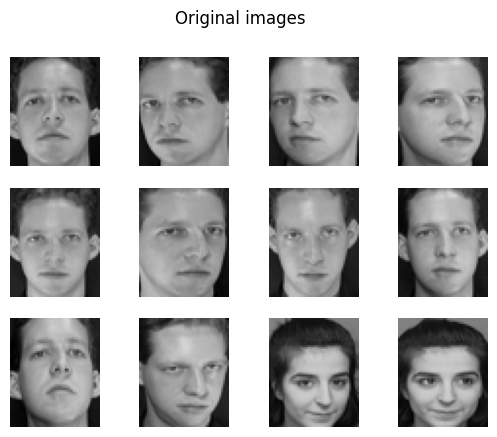

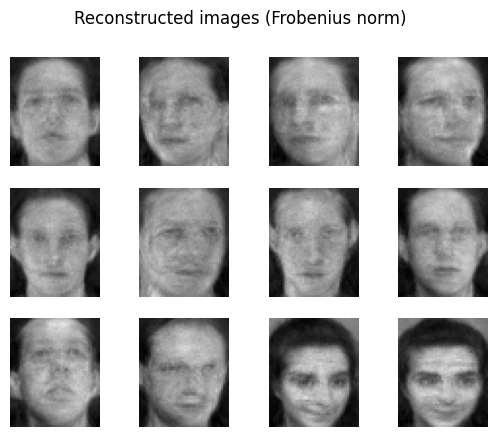

In [ ]:
# define the l2 loss function
def loss_fnorm2(X, D, R):
    return np.linalg.norm(X - np.matmul(D, R), "fro").item()

# define one iteration of the gradient descent for the multiplicative rule on
# D and R
def optim_fnorm2(X, D, R, need_lr=False):
    A = D.T @ D @ R
    if need_lr:
        lr_R = R / A
    R *= (D.T @ X) / A + 1e-7
    B = D @ R @ R.T
    if need_lr:
        lr_D = D / B
    D *= (X @ R.T) / B + 1e-7
    if need_lr:
        return lr_R, lr_D
    return None

# Test run of the l2 norm optimisation, with images to confirm that the model
# is behaving correctly
def fro_norm_nmf(X, r, n_epoch,
                 *,
                 regularization=None,
                 early_stopping=None,
                 print_freq=None):
    if r < 1:
        r = int(round(r * X.shape[0]))
    D, R = init_nmf(X, r)
    if early_stopping is not None:
        early_stopping.reset()
    for epoch in range(n_epoch):
        lr = optim_fnorm2(X, D, R, regularization)
        loss = loss_fnorm2(X, D, R)
        if regularization:
            lr_R, lr_D = lr
            D = np.maximum(D - lr_D * regularization, 0)
            R = np.maximum(R - lr_R * regularization, 0)
        if early_stopping and early_stopping(loss):
            break
        if print_freq and epoch % print_freq == 0:
            print(f"{epoch = } {loss = }")
    return D, R

D, R = fro_norm_nmf(X_orl, 0.1, 200, print_freq=20)

display_images(X_orl, *shape_orl, n_sample=12)
plt.suptitle("Original images")
display_images(D @ R, *shape_orl, n_sample=12)
plt.suptitle("Reconstructed images (Frobenius norm)")
plt.show()

## 2.4 Robustness

### 2.4.1 Definitions

Let $Z \in \mathbb R^{h \times w}$ be the noise matrix we add element-wise to each image $X \in \mathbb R_+^{h \times w}$ where $h$ and $w$ are the height and width of the image respectively, there are three types of noise defined below and demonstrated in figures.

**Gaussian noise.** Noise that follows a normal distribution. $Z_{ij} \sim \mathcal N(\mu, \sigma^2)$ where the parameters default to $\mu = 0$ and $\sigma = 25$.

**Block noise.** A randomly positioned white square block. $Z_{ij} = 255 \times 1_{\{(i, j) \in \mathcal B\}}$ where $\mathcal B = [I, I + k] \times [J, J + k]$ is a square block of size $k$. The pair $(I, J)$ is a random variable that represents the top left corner of $\mathcal B$. The indexes $I$ and $J$ are randomly sampled from discrete uniform distributions $\mathcal U\{1, h - k\}$ and $\mathcal U\{1, w - k\}$ respectively. The parameter $k$ defaults to $0.3$ minimum side length of the original image and controls the side length of the block.

**Grid noise.** A randomly positioned grid of white square blocks with a fixed horizontal the vertical gaps between adjacent ones. There are two control parameters: $k$ for the size of the blocks in grid, and $l$ for the gap between the blocks. The noise can be seen as a repetition of the $(k + l) \times (k + l)$ matrix
$$
255
\begin{bmatrix}
    I_k & 0_{k \times l} \\
    0_{l \times k} & 0_{l \times l}
\end{bmatrix}.
$$

The noise is then a tiling of $\big(\lceil \frac{h}{k+l}\rceil + 1\big)$ rows and $\big(\lceil \frac{w}{k+l}\rceil + 1\big)$ columns of such matrices, that would cover the image allowing offset of up to but not including $(k + l)$ both vertically and horizontally. The offset $(I, J)$ is randomly chosen where $I, J \sim \mathcal U\{0, k + l - 1\}$.

In [ ]:
# return blank delta as no noise
def no_noise(X, __dim):
    return np.zeros_like(X)

# each pixel is drawn from a random distribution
def gaussian_noise(X, __dim, mu=0, sigma=.1):
    if sigma < 1:
        sigma *= PIXEL_MAX
    return mu + np.random.randn(*X.shape) * sigma

# a random location in the image is chosen where a square (with width that is
# 0.3 times the smaller dimension of the image) is used as a pure white mask
def block_noise(X, dim, size=.3):
    d, n = X.shape
    if size < 1:
        size = int(round(size * min(dim)))
    I = np.random.randint(1, dim[0] - size, n) - 1
    J = np.random.randint(1, dim[1] - size, n) - 1
    noise = np.zeros((*dim, n))
    for i, j, k in zip(I, J, range(n)):
        noise[i:i + size + 1, j:j + size + 1, k] = PIXEL_MAX
    return noise.reshape((d, n))

# small squares (0.1 times the smaller dimension of the image) separated by
# gaps (0.2 times the smaller dimension of the image) are distributed in
# random locations on the image.
def grid_noise(X, dim, size=.1, gap=.2):
    d, n = X.shape
    if size < 1:
        size = int(round(size * min(dim)))
    if gap < 1:
        gap = int(round(gap * min(dim)))
    block = np.zeros((size + gap,) * 2)
    block[:size, :size] = 255
    reps = (int(np.ceil(dim[0] / (size + gap))) + 1,
            int(np.ceil(dim[1] / (size + gap))) + 1)
    grid = np.tile(block, reps)
    offsets = (np.random.randint(0, grid.shape[0] - dim[0] + 1, n),
               np.random.randint(0, grid.shape[1] - dim[1] + 1, n))
    noise = []
    for i, offset in enumerate(zip(*offsets)):
        noise.append(grid[offset[0]:offset[0] + dim[0],
                          offset[1]:offset[1] + dim[1]])
    return np.stack(noise, axis=2).reshape((d, n))

### 2.4.2 Visualisations

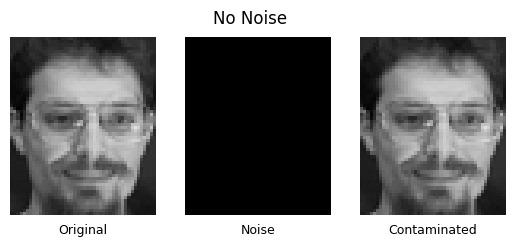

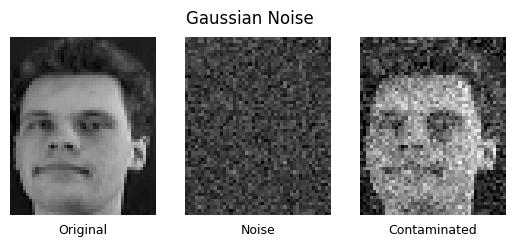

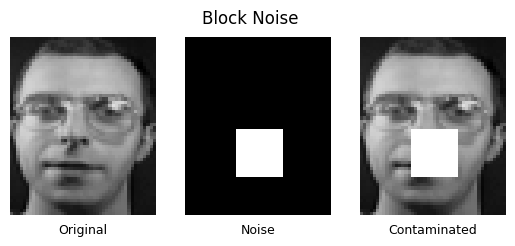

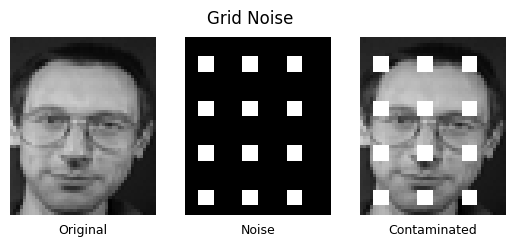

In [ ]:
# visualisation of the noises to confirm that they are all working correctly
X_original = X_orl
dim = shape_orl

for noise_fn in (no_noise, gaussian_noise, block_noise, grid_noise):
    name = noise_fn.__qualname__.replace("_", " ").title()
    noise = noise_fn(X_original, dim)
    fig, axes = plt.subplots(1, 3, figsize=(6.4, 2.4))
    X_noised = np.clip(X_original + noise, 0, PIXEL_MAX)
    i = random.randint(0, noise.shape[1] - 1)
    for ax, mat, title in zip(
        axes,
        (X_original, noise, X_noised),
        ("Original", "Noise", "Contaminated")
    ):
        ax.set_title(title, {"fontsize": 9}, y=-0.15)
        ax.imshow(mat[:, i].reshape(*dim), cmap="gray", vmax=PIXEL_MAX)
        ax.set_axis_off()
    fig.suptitle(name)
plt.show()

## 2.5 Metrics

### 2.5.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$

### 2.5.2 Evaluate Clustering Performance

1.  Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


2.  Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.

In [ ]:
# A standard K-means clustering algorithm
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]
    return Y_pred

# 3. Experiments

In [ ]:
# setup experiments folder
from pathlib import Path

exp_dir = Path("experiments")
if not exp_dir.exists():
    exp_dir.mkdir(exist_ok=True)

## 3.1 Learning Rate Experiment

In [ ]:
# An experiment testing the learning rates 1, 0.1, 0.01 and 0.001 on both of the
# NMF algorithms on both the datasets. Only Gaussian noise was used as this
# was a basic test of the appropriate learning rate to choose.
from tqdm.auto import tqdm
from tqdm.contrib.itertools import product
import pandas as pd

nmfs = [
    (l1_norm_nmf, {
        "n_epoch": 2_000,
        "early_stopping": EarlyStopping(100, 0),
    })
]

datasets = ['ORL', 'CroppedYaleB']

lr_space = np.pow(10.0, np.arange(-3, 1))

reduce_ratio = {
    'ORL': 3,
    'CroppedYaleB': 4,
}

n_splits = 10

results = []

np.random.seed(42)

for exp in product(nmfs, datasets, lr_space, desc="experiments"):
    (nmf, nmf_kwargs), dataset, lr = exp

    nmf_name = nmf.__name__.removesuffix("nmf").strip().replace("_", " ").title()

    V_hat, Y_hat, img_size = load_data(f"data/{dataset}", reduce=reduce_ratio[dataset])

    V_hat_train = V_hat
    Y_hat_train = Y_hat

    V_train_noise = gaussian_noise(V_hat_train, img_size)
    V_train = np.clip(V_hat_train + V_train_noise, 0, PIXEL_MAX)

    # Optimize
    W, H = nmf(V_train, **nmf_kwargs | {'r': len(set(Y_hat)), "lr": lr})

    # Evaluate relative reconstruction errors.
    rre = np.linalg.norm(V_hat_train - W.dot(H)) / np.linalg.norm(V_hat_train)

    # Assign cluster labels.
    Y_train_pred = assign_cluster_label(H.T, Y_hat_train)
    acc = accuracy_score(Y_hat_train, Y_train_pred)
    nmi = normalized_mutual_info_score(Y_hat_train, Y_train_pred)

    results.append({
        "Loss": nmf_name,
        "Dataset": dataset,
        "Learning Rate": lr,
        "RRE": rre,
        "ACC": acc,
        "NMI": nmi,
    })

df_lr = pd.DataFrame(results).iloc[:, 1:].set_index(["Dataset"])
df_lr.to_csv("experiments/tune_lr.csv")
df_lr

experiments:   0%|          | 0/8 [00:00<?, ?it/s]

,Learning Rate,RRE,ACC,NMI
Dataset,,,,
ORL,0.001,2.859133e-01,0.190000,0.356531
ORL,0.010,1.884772e-01,0.697500,0.819253
ORL,0.100,1.586357e-01,0.745000,0.849341
ORL,1.000,5.805521e+12,0.217500,0.400024
CroppedYaleB,0.001,5.432838e-01,0.079536,0.076782
CroppedYaleB,0.010,3.264801e-01,0.086164,0.082797
CroppedYaleB,0.100,2.039373e-01,0.217067,0.288382
CroppedYaleB,1.000,2.903834e+13,0.082022,0.078211


## 3.2 No. Components Experiment

In [ ]:
# Similarly, this is an experiment to test the best number of components to set
# for the NMF, and only uses Gaussian noise.
from time import perf_counter

nmfs = [
    (l1_norm_nmf, {
        "n_epoch": 2_000,
        "lr": 0.1,
        "early_stopping": EarlyStopping(100, 1e-3),
    }),
    (fro_norm_nmf, {
        "n_epoch": 2_000,
        "early_stopping": EarlyStopping(100, 1e-3),
    })
]

datasets = ['ORL', 'CroppedYaleB']

r_space = [10, 20, 50, 100, 200]

reduce_ratio = {
    'ORL': 3,
    'CroppedYaleB': 4,
}

n_splits = 10

results = []

np.random.seed(42)

for exp in product(nmfs, datasets, r_space, desc="experiments"):
    (nmf, nmf_kwargs), dataset, r = exp

    nmf_name = nmf.__name__.removesuffix("nmf").strip().replace("_", " ").title()

    V_hat, Y_hat, img_size = load_data(f"data/{dataset}", reduce=reduce_ratio[dataset])

    V_hat_train = V_hat
    Y_hat_train = Y_hat

    V_train_noise = gaussian_noise(V_hat_train, img_size)
    V_train = np.clip(V_hat_train + V_train_noise, 0, PIXEL_MAX)

    # Optimize
    start = perf_counter()
    W, H = nmf(V_train, **nmf_kwargs | {'r': r})
    end = perf_counter()

    # Evaluate relative reconstruction errors.
    rre = np.linalg.norm(V_hat_train - W.dot(H)) / np.linalg.norm(V_hat_train)

    # Assign cluster labels.
    Y_train_pred = assign_cluster_label(H.T, Y_hat_train)
    acc = accuracy_score(Y_hat_train, Y_train_pred)
    nmi = normalized_mutual_info_score(Y_hat_train, Y_train_pred)

    results.append({
        "Loss": nmf_name,
        "Dataset": dataset,
        "No. of Components": r,
        "RRE": rre,
        "ACC": acc,
        "NMI": nmi,
        "Time": end - start,
    })

df_ncomp = pd.DataFrame(results).set_index(["Loss", "Dataset"])
df_ncomp.to_csv(f"experiments/tune_r.csv")
df_ncomp

experiments:   0%|          | 0/20 [00:00<?, ?it/s]

No. of Components       RRE       ACC       NMI  \
Loss      Dataset                                                         
L1 Norm   ORL                          10  0.190763  0.632500  0.791433   
          ORL                          20  0.172772  0.682500  0.813643   
          ORL                          50  0.159059  0.687500  0.829497   
          ORL                         100  0.156153  0.682500  0.809714   
          ORL                         200  0.159910  0.575000  0.735056   
          CroppedYaleB                 10  0.261207  0.152030  0.174468   
          CroppedYaleB                 20  0.230074  0.182684  0.260892   
          CroppedYaleB                 50  0.194311  0.231152  0.298249   
          CroppedYaleB                100  0.175671  0.264292  0.331278   
          CroppedYaleB                200  0.162679  0.252278  0.313228   
Fro Norm  ORL                          10  0.185691  0.642500  0.807133   
          ORL                          20  0.162688  0.690000  0.823007   
          ORL                          50  0.140685  0.677500  0.814745   
          ORL                         100  0.138487  0.685000  0.808632   
          ORL                         200  0.150713  0.520000  0.674985   
          CroppedYaleB                 10  0.256317  0.128003  0.170250   
          CroppedYaleB                 20  0.224271  0.189312  0.262703   
          CroppedYaleB                 50  0.181986  0.239022  0.324180   
          CroppedYaleB                100  0.155026  0.290389  0.375333   
          CroppedYaleB                200  0.138021  0.285833  0.343563   

                              Time  
Loss      Dataset                   
L1 Norm   ORL             3.972298  
          ORL             4.200498  
          ORL             7.197156  
          ORL             9.014702  
          ORL             8.617153  
          CroppedYaleB   63.572449  
          CroppedYaleB   67.714257  
          CroppedYaleB   89.502513  
          CroppedYaleB   97.061341  
          CroppedYaleB  110.097688  
Fro Norm  ORL             1.091697  
          ORL             1.338818  
          ORL             1.828082  
          ORL             4.781490  
          ORL             9.210243  
          CroppedYaleB    7.525810  
          CroppedYaleB   10.383520  
          CroppedYaleB   19.682547  
          CroppedYaleB   27.704139  
          CroppedYaleB   46.378880

## 3.3 Main Experiment

In [ ]:
from sklearn.model_selection import StratifiedKFold

nmfs = [
    (l1_norm_nmf, {
        "n_epoch": 2_000,
        "lr": 0.05,
    }),
    (fro_norm_nmf, {
        "n_epoch": 2_000,
    })
]
datasets = ['ORL', 'CroppedYaleB']
noises =  [no_noise, gaussian_noise, block_noise, grid_noise]

reduce_ratio = {
    'ORL': 3,
    'CroppedYaleB': 4,
}

n_splits = 10

results = []

np.random.seed(42)

for exp in product(nmfs, datasets, noises, desc="experiments"):
    (nmf, nmf_kwargs), dataset, noise = exp

    nmf_name = nmf.__name__.removesuffix("nmf").strip().replace("_", " ").title()
    noise_name = noise.__name__.replace("_", " ").title()

    V_hat, Y_hat, img_size = load_data(f"data/{dataset}", reduce=reduce_ratio[dataset])

    kfold_splits = StratifiedKFold(n_splits=n_splits, shuffle=True).split(V_hat.T, Y_hat)

    for i, split in enumerate(tqdm(kfold_splits, desc="k-fold", total=n_splits, leave=False)):
        V_hat_train = V_hat[:, split[0]]
        Y_hat_train = Y_hat[split[0]]

        V_train_noise = noise(V_hat_train, img_size)
        V_train = np.clip(V_hat_train + V_train_noise, 0, PIXEL_MAX)

        # Optimize
        W, H = nmf(V_train, **nmf_kwargs | {'r': len(set(Y_hat))})

        # Evaluate relative reconstruction errors.
        rre = np.linalg.norm(V_hat_train - W.dot(H)) / np.linalg.norm(V_hat_train)

        # Assign cluster labels.
        Y_train_pred = assign_cluster_label(H.T, Y_hat_train)

        acc = accuracy_score(Y_hat_train, Y_train_pred)
        nmi = normalized_mutual_info_score(Y_hat_train, Y_train_pred)

        display_images(W @ H, *img_size)
        dir_path = (Path("experiments")
                    / nmf.__name__ / dataset.lower() / noise.__name__)
        dir_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(dir_path / f"{i}.png")
        plt.close()

        results.append({
            "Loss": nmf_name,
            "Dataset": dataset,
            "Noise": noise_name,
            "Fold": i,
            "RRE": rre,
            "ACC": acc,
            "NMI": nmi,
        })

df = pd.DataFrame(results)
df.to_csv(f"experiments/main.csv")

def mean(x):
    return np.round(np.mean(x), 3)

def std(x):
    return np.round(np.std(x), 5)

df_final = (
    df
    .drop(columns="Fold")
    .groupby(["Loss", "Dataset", "Noise"], sort=False)
    .agg([mean, std])
)
print(df_final.to_latex(formatters={
    ("RRE", "mean"): lambda x: f"{x:.3f}",
    ("RRE", "std"): lambda x: f"{x:.5f}",
    ("ACC", "mean"): lambda x: f"{x:.3f}",
    ("ACC", "std"): lambda x: f"{x:.5f}",
    ("NMI", "mean"): lambda x: f"{x:.3f}",
    ("NMI", "std"): lambda x: f"{x:.5f}",
}))